In [1]:
import rasterio
import matplotlib 
import matplotlib.pyplot as plt
import os
import numpy as np
import re
from matplotlib import gridspec
from numpy import newaxis
import matplotlib.image as mpimg

matplotlib.rc('text', usetex = False)

In [2]:
class classes:
    classes_MCD12Q1v6LCProp2 = ['NoData',
        'Barren',
        'Water Bodies',
        'Urban and Built-up Lands',
        'Dense Forests',
        'Open Forests',
        'Natural Herbaceous',
        'Herbaceous Croplands',
        'Shrublands' ]

    short_MCD12Q1v6LCProp2 = ['NoData','Ba', 
                                 'W', 'Bu','DF', 
                              'OF', 'NH', 
                                'HC','S']
        
    colors_MCD12Q1v6LCProp2 = [ '#ababab', '#f9ffa4', 
                               '#1c0dff','#fa0000', '#003f00', 
                               '#006c00', '#b6ff05', 
                               '#f096ff', '#dcd159' ]

In [3]:
dataset_config = {
        'MCD12Q1v6stable01to15_LCProp2_major': {
            'classes': classes.classes_MCD12Q1v6LCProp2,
            'shortname': classes.short_MCD12Q1v6LCProp2,
            'colors': classes.colors_MCD12Q1v6LCProp2, 
            'name': 'M8*'}
    }

In [4]:
def read_file(file):
    with rasterio.open(file) as src:
        return (src.read(1))

In [5]:
def plot_year(post_files, colormap, vmin, vmax, title):
    gridspec_kwargs = dict(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.05, hspace=0.2)

    fig, axes = plt.subplots(nrows=7, ncols=1, sharex=False, sharey=False, figsize=(20, 10), gridspec_kw=gridspec_kwargs)

    axs = axes.flatten()

    for i, data in enumerate(post_files):
#         axs[i].set_title(str(i+yS), fontsize='xx-large')
        axs[i].imshow(data, cmap=colormap, interpolation='none', vmin=vmin, vmax=vmax) 
        axs[i].axis('off')
        
    fig.text(0.45, 0.5, title, fontsize='xx-large', weight='bold', ha='center', va='center', rotation='vertical')

    plt.tight_layout()   

In [4]:
tiles = ['tile_0_201', 'tile_0_143', 'tile_1_463',  'tile_0_365', 'tile_1_438', 'tile_1_713', 'tile_0_630']
tiles_modis = ['h10v08','h11v08','h10v09','h12v09','h13v09','h11v10','h12v10']
datasets = ['MCD12Q1v6stable01to15_LCProp2_major']
bms = [3, 1, 5]
models = ['RF','SVM','MTLCC']
tyear = 2003
rottdir = r'F:\acoca\research\gee\dataset'

In [3]:
tiles_ids = [i[5:] for i in tiles]

gs0 = gridspec.GridSpec(1, 4,  wspace=0.1, width_ratios = [0.7, 1, 1, 1])
fig = plt.figure(figsize=(9, 9), constrained_layout=False)

for d in datasets:
    for x, m in enumerate(models):
        gs00 = gridspec.GridSpecFromSubplotSpec(7, 1, wspace=0.1, subplot_spec=gs0[0])
        gs01 = gridspec.GridSpecFromSubplotSpec(7, 2, wspace=0.1, subplot_spec=gs0[x+1])

        indir_gt = r'E:\acocac\research\AMZ\eval\verification\{}\{}'.format(d,tyear)

        if m == 'MTLCC':
            indir_pred = r'E:\acocac\research\AMZ\eval\pred\4_local\convgru\{}\{}\prediction'.format(bms[x],tyear)
        else:
            indir_pred = r'E:\acocac\research\AMZ\eval\pred\3_comparison\{}\{}_ssize3000_200120022003_MCD12Q1v6stable01to15_LCProp2_major\{}\{}\prediction'.format(m, m, bms[x],tyear)

        colors = dataset_config[d]['colors']
        labels = dataset_config[d]['classes']
        shorts = dataset_config[d]['shortname']
        name_dataset = dataset_config[d]['name']

        n_labels = len(colors)-1
        colormap = matplotlib.colors.LinearSegmentedColormap.from_list(range(n_labels),colors)
        #load files
        array_pred = [read_file(os.path.join(indir_pred,'0_' + x + '.tif')) for x in tiles_ids]
        array_gt = [read_file(os.path.join(indir_gt,'0_' + x + '.tif')) for x in tiles_ids]

        array_pred_stack = np.stack(array_pred) #stack
        array_gt_stack = np.stack(array_gt) #stack
    
        array_pred_stack = array_pred_stack[newaxis, :, :, :]
        array_gt_stack = array_gt_stack[newaxis, :, :, :]
        
        array_merge = np.vstack([array_gt_stack, array_pred_stack])
        
        array_concat = np.concatenate((array_pred_stack,array_gt_stack),axis=0)
        uniqueValues = uniqueValues = np.unique(array_concat)
        uniqueValues = uniqueValues.astype(int).tolist()
        uniqueValues = uniqueValues

        # Extracting handles and labels
        newcolors = [colors[i] for i in uniqueValues]
        newlabels = [shorts[i] for i in uniqueValues]

        list_aoi = [mpimg.imread(os.path.join(r'E:\acocac\research\AMZ\img\c5\aois','map_aoi_' + x + '.png')) for x in tiles]
        
#         gs00.title('as') # title for each outer frame

        for j in range(array_merge.shape[0]):
            for y, data in enumerate(array_merge[j,:,:,:]):
                if j == 0:
                    ax00 = fig.add_subplot(gs00[y, j])
                    ax00.text(-2,-2, tiles_modis[y], size='large', ha="center")
#                     ax00.set_title('Tiles', size='large', ha="center")
#                     ax01.set_title('Gtruth', size='large',ha="center")
                    ax00.imshow(list_aoi[y])
                    ax00.axis('off')

                ax01 = fig.add_subplot(gs01[y, j])
                if j == 0 and y ==0:
                    ax01.set_title('labels ' + r'$y$', size='large',ha="center")
                    ax01.text(400,-140, m, size='large',ha="center",weight='bold')

                if j == 1 and y ==0:
                    ax01.set_title('pred. ' +  r'$\^y$', size='large', ha="center")
                ax01.imshow(data, cmap=colormap, interpolation='none', vmin=0, vmax=len(colors)-1) 

                #                 if y == 0 and j ==0:
#                     handles = [f("s", newcolors[i]) for i in range(len(newcolors))]
#                     leg = ax01.legend(handles, newlabels, fontsize = 'small', bbox_to_anchor=(2, 3), ncol=2, markerscale=1, borderpad=0.6, handletextpad=0.05, frameon=True)
#                     leg.set_title(name_dataset, prop={'size': 'medium', 'weight': 'heavy'})

                ax01.axis('off')
    # fig.axis('off')         
    # plt.show()

NameError: name 'gridspec' is not defined

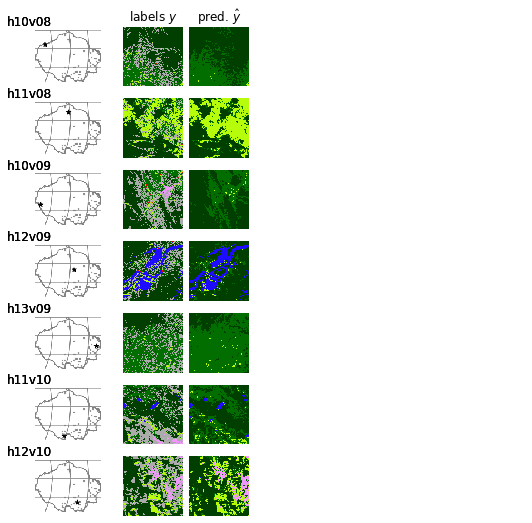

In [13]:
tiles_ids = [i[5:] for i in tiles]

gs0 = gridspec.GridSpec(1, 4,  wspace=0.1, width_ratios = [0.7, 1, 1, 1])
fig = plt.figure(figsize=(9, 9), constrained_layout=False)

for d in datasets:
    for x, m in enumerate(models):
        gs00 = gridspec.GridSpecFromSubplotSpec(7, 1, wspace=0.1, subplot_spec=gs0[0])
        gs01 = gridspec.GridSpecFromSubplotSpec(7, 2, wspace=0.1, subplot_spec=gs0[x+1])

        indir_gt = r'E:\acocac\research\AMZ\eval\verification\{}\{}'.format(d,tyear)

        if m == 'MTLCC':
            indir_pred = r'E:\acocac\research\AMZ\eval\pred\4_local\convgru\{}\{}\prediction'.format(bms[x],tyear)
        else:
            indir_pred = r'E:\acocac\research\AMZ\eval\pred\3_comparison\{}\{}_ssize3000_200120022003_MCD12Q1v6stable01to15_LCProp2_major\{}\{}\prediction'.format(m, m, bms[x],tyear)

        colors = dataset_config[d]['colors']
        labels = dataset_config[d]['classes']
        shorts = dataset_config[d]['shortname']
        name_dataset = dataset_config[d]['name']

        n_labels = len(colors)-1
        colormap = matplotlib.colors.LinearSegmentedColormap.from_list(range(n_labels),colors)
        #load files
        array_pred = [read_file(os.path.join(indir_pred,'0_' + x + '.tif')) for x in tiles_ids]
        array_gt = [read_file(os.path.join(indir_gt,'0_' + x + '.tif')) for x in tiles_ids]

        array_pred_stack = np.stack(array_pred) #stack
        array_gt_stack = np.stack(array_gt) #stack
    
        array_pred_stack = array_pred_stack[newaxis, :, :, :]
        array_gt_stack = array_gt_stack[newaxis, :, :, :]
        
        array_merge = np.vstack([array_gt_stack, array_pred_stack])
        
        array_concat = np.concatenate((array_pred_stack,array_gt_stack),axis=0)
        uniqueValues = uniqueValues = np.unique(array_concat)
        uniqueValues = uniqueValues.astype(int).tolist()
        uniqueValues = uniqueValues

        # Extracting handles and labels
        newcolors = [colors[i] for i in uniqueValues]
        newlabels = [shorts[i] for i in uniqueValues]

        list_aoi = [mpimg.imread(os.path.join(r'E:\acocac\research\AMZ\img\c5\aois','map_aoi_' + x + '.png')) for x in tiles]
        
        for j in range(array_merge.shape[0]):
            for y, data in enumerate(array_merge[j,:,:,:]):
                if j == 0:
                    ax00 = fig.add_subplot(gs00[y, j])
                    ax00.text(-2,-2, tiles_modis[y], size='large', ha="center")
#                     ax00.set_title('Tiles', size='large', ha="center")
#                     ax01.set_title('Gtruth', size='large',ha="center")
                    ax00.imshow(list_aoi[y])
                    ax00.axis('off')

                ax01 = fig.add_subplot(gs01[y, j])
                if m == 'MTLCC':
                    if j == 0 and y ==0:
                        ax01.set_title('labels ' + r'$y$', size='large',ha="center")
                    if j == 1 and y ==0:
                        ax01.set_title('pred. ' +  r'$\^y$', size='large', ha="center")
                    ax01.imshow(data, cmap=colormap, interpolation='none', vmin=0, vmax=len(colors)-1) 
                
                if m != 'MTLCC':
                    if j == 0 and y ==0:
                        ax01.set_title('labels ' + r'$y$', size='large',ha="center")
                    if j == 1 and y ==0:
                        ax01.set_title('pred. ' +  r'$\^y$', size='large', ha="center")
                    ax01.imshow(data, cmap=colormap, interpolation='none', vmin=0, vmax=len(colors)-1) 
                  

                ax01.axis('off')
    # fig.axis('off')         
    # plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)


# gridspec inside gridspec

f = plt.figure()

gs0 = gridspec.GridSpec(1, 2)

gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])

ax1 = plt.Subplot(f, gs00[:-1, :])
f.add_subplot(ax1)
ax2 = plt.Subplot(f, gs00[-1, :-1])
f.add_subplot(ax2)
ax3 = plt.Subplot(f, gs00[-1, -1])
f.add_subplot(ax3)


gs01 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[1])

ax4 = plt.Subplot(f, gs01[:, :-1])
f.add_subplot(ax4)
ax5 = plt.Subplot(f, gs01[:-1, -1])
f.add_subplot(ax5)
ax6 = plt.Subplot(f, gs01[-1, -1])
f.add_subplot(ax6)

plt.suptitle("GirdSpec Inside GridSpec")
make_ticklabels_invisible(plt.gcf())

plt.show()


In [ ]:
aoi = mpimg.imread(os.path.join(indir,'map_aoi_' + tile + '.png')) 
legend = mpimg.imread(os.path.join(outdir,'legend_terrai.png'))

gs0 = gridspec.GridSpec(2, 4,  hspace=0.2, wspace=0.1, height_ratios= [0.6, 1])
arrays_l1 = [aoi,legend, water,terra_raw,terra_water,terra_clump]

fig = plt.figure(figsize=(16, 8), constrained_layout=False)
for i, arr in enumerate(arrays_l1):
    if i == 0:
        ax00 = fig.add_subplot(gs0[0, 0])
        ax00.imshow(arr)
    elif i == 1:
        ax00 = fig.add_subplot(gs0[0, 1:])
        ax00.imshow(arr)
    elif i == 2:
        ax00 = fig.add_subplot(gs0[1, i-2])
        ax00.set_title('\n Watermask \n', fontsize='x-large')
        ax00.imshow(arr, cmap=colormap_water, interpolation='none', vmin=0, vmax=1)
    else:
        if i == 3:
            trat = '\n Raw'
        elif i == 4:
            trat = '\n mask 1 (water)'
        elif i == 5:
            trat = '\n mask 1 (water) + mask 2 (isolated)'
        N = Counter(arr.flatten())[1.0]
        ax00 = fig.add_subplot(gs0[1, i-2])
        ax00.set_title('Terra-i ' + trat + '\n (N=' + str(N) + ')', fontsize='x-large')
        ax00.imshow(arr, cmap=colormap_terra, interpolation='none', vmin=0, vmax=1)
    ax00.axis('off')
    
plt.show()

fig.savefig(os.path.join(outdir,'terrai_preprocessed.png'), bbox_inches='tight',pad_inches = 0, dpi=150)
plt.close()